# 1.8f2: Three-Population View from Origin

This notebook visualizes the spatial relationship between cluster, halo, and bulk tokens **from the origin of coordinates** (not the cluster centroid).

## The Question

In 1.8f, we viewed token space from the cluster's perspective. Now we want **God's eye view**—from the origin where (presumably) all tokens were initialized.

This will reveal:
- Is the asymmetry we saw cluster-centric or absolute?
- Where is the cluster relative to the initialization point?
- How did the vocabulary expand from origin?

## Method

Identical to 1.8f, except:
- **Origin**: Coordinate origin (zero vector), not cluster centroid
- **Spherical coords**: Computed from origin
- Same PCA basis (from cluster analysis) for consistency

## Parameters

In [ ]:
# Model
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Spherical coordinate system (using cluster's PCA basis for consistency)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Volume filter
R_MIN = 0.0
R_MAX = 1.0
Z_MIN = -1.0
Z_MAX = 1.0

# Point size scaling (inverse square)
BASE_SIZE = 500
EPSILON = 0.05

# Colors and transparency
CLUSTER_COLOR = 'red'
HALO_COLOR = 'orange'
BULK_COLOR = 'steelblue'

CLUSTER_ALPHA = 0.8
HALO_ALPHA = 0.6
BULK_ALPHA = 0.3

# Visualization
FIGSIZE = (16, 8)
DPI = 200

## Imports

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [28]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [29]:
# Load W (full vocabulary)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions


In [30]:
# Load reference frame (for PCA basis)
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
cluster_centroid = ref_data['cluster_centroid'].to(device)  # For reference only
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded reference frame:")
print(f"  Cluster centroid norm: {torch.linalg.vector_norm(cluster_centroid).item():.6f}")
print(f"  PCA eigenvectors: {eigenvectors.shape}")
print(f"\n  NOTE: Using PCA basis from cluster analysis for consistency")
print(f"        but computing coordinates FROM ORIGIN, not cluster centroid")


Loaded reference frame:
  Cluster centroid norm: 0.370917
  PCA eigenvectors: torch.Size([2560, 2560])

  NOTE: Using PCA basis from cluster analysis for consistency
        but computing coordinates FROM ORIGIN, not cluster centroid


In [31]:
# Load population masks from 1.8e
pop_path = Path(f"../tensors/{MODEL_NAME}/1.8e_unreachable_tokens.safetensors")
pop_data = load_file(pop_path)

cluster_mask = pop_data['cluster_mask']
halo_mask = pop_data['halo_mask']
unreachable_mask = pop_data['unreachable_mask']
bulk_mask = ~unreachable_mask

print(f"\nLoaded population masks:")
print(f"  Cluster: {cluster_mask.sum().item():,} tokens")
print(f"  Halo: {halo_mask.sum().item():,} tokens")
print(f"  Bulk: {bulk_mask.sum().item():,} tokens")


Loaded population masks:
  Cluster: 2,212 tokens
  Halo: 1,423 tokens
  Bulk: 148,579 tokens


## Define Spherical Basis

In [32]:
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"\nSpherical basis (from cluster PCA):")
print(f"  North: PC{NORTH_PC}")
print(f"  Meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")


Spherical basis (from cluster PCA):
  North: PC3
  Meridian: PC1
  Equinox: PC2


## Compute Spherical Coordinates FROM ORIGIN

In [33]:
print("\nComputing spherical coordinates for ALL tokens FROM ORIGIN...\n")

# KEY DIFFERENCE: W is already origin-centered (no subtraction)
# We're using W directly, not W - cluster_centroid

# Project onto basis
x = W @ meridian
y = W @ equinox
z = W @ north

# Spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"✓ Spherical coordinates computed for all {N:,} tokens")
print(f"\nRadial distance statistics (from ORIGIN):")
print(f"  Min: {r.min().item():.6f}")
print(f"  Max: {r.max().item():.6f}")
print(f"  Mean: {r.mean().item():.6f}")
print(f"  Median: {r.median().item():.6f}")

# For comparison: cluster centroid distance from origin
cluster_r = torch.linalg.vector_norm(cluster_centroid).item()
print(f"\nFor reference:")
print(f"  Cluster centroid from origin: {cluster_r:.6f}")


Computing spherical coordinates for ALL tokens FROM ORIGIN...

✓ Spherical coordinates computed for all 151,936 tokens

Radial distance statistics (from ORIGIN):
  Min: 0.003706
  Max: 0.827435
  Mean: 0.284388
  Median: 0.300220

For reference:
  Cluster centroid from origin: 0.370917


## Filter to Target Volume

In [34]:
print(f"\nFiltering to volume: r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN}, {Z_MAX}]\n")

# Apply volume filters
volume_mask = (r >= R_MIN) & (r <= R_MAX) & (z >= Z_MIN) & (z <= Z_MAX)
n_filtered = volume_mask.sum().item()

# Extract filtered coordinates
r_filtered = r[volume_mask]
lat_deg_filtered = lat_deg[volume_mask]
lon_deg_filtered = lon_deg[volume_mask]
z_filtered = z[volume_mask]

# Filter population masks to match volume
cluster_mask_filtered = cluster_mask[volume_mask.cpu()]
halo_mask_filtered = halo_mask[volume_mask.cpu()]
bulk_mask_filtered = bulk_mask[volume_mask.cpu()]

print(f"✓ Filtered to {n_filtered:,} tokens")
print(f"  ({100 * n_filtered / N:.3f}% of vocabulary)")
print(f"\nFiltered dataset statistics:")
print(f"  r: [{r_filtered.min().item():.6f}, {r_filtered.max().item():.6f}]")
print(f"  z: [{z_filtered.min().item():.6f}, {z_filtered.max().item():.6f}]")
print(f"\nPopulation breakdown in filtered volume:")
print(f"  Cluster: {cluster_mask_filtered.sum().item():,} tokens")
print(f"  Halo: {halo_mask_filtered.sum().item():,} tokens")
print(f"  Bulk: {bulk_mask_filtered.sum().item():,} tokens")


Filtering to volume: r ∈ [0.0, 1.0], z ∈ [-1.0, 1.0]

✓ Filtered to 151,936 tokens
  (100.000% of vocabulary)

Filtered dataset statistics:
  r: [0.003706, 0.827435]
  z: [-0.210989, 0.173561]

Population breakdown in filtered volume:
  Cluster: 2,212 tokens
  Halo: 1,423 tokens
  Bulk: 148,579 tokens


## Compute Point Sizes (Inverse Square)

In [35]:
print("\nComputing point sizes (inverse square scaling)...\n")

# Convert to numpy
r_np = r_filtered.cpu().numpy()
lat_np = lat_deg_filtered.cpu().numpy()
lon_np = lon_deg_filtered.cpu().numpy()

# Inverse square scaling: close = MUCH bigger, far = much smaller
r_max = r_np.max()
r_min = r_np.min()

# Normalize distances to [0, 1] range
r_normalized = (r_np - r_min) / (r_max - r_min + 1e-10)

# Inverse square with offset to prevent division by zero
sizes = BASE_SIZE * (1 / (r_normalized + EPSILON))**2

# Rescale to reasonable range
sizes = sizes / sizes.max() * BASE_SIZE

print(f"✓ Point sizes computed")
print(f"  Size range: [{sizes.min():.2f}, {sizes.max():.2f}]")
print(f"  Mean size: {sizes.mean():.2f}")


Computing point sizes (inverse square scaling)...

✓ Point sizes computed
  Size range: [1.13, 500.00]
  Mean size: 12.64


## Mollweide Sky Map: Three Populations


Creating Mollweide sky map (view from origin)...



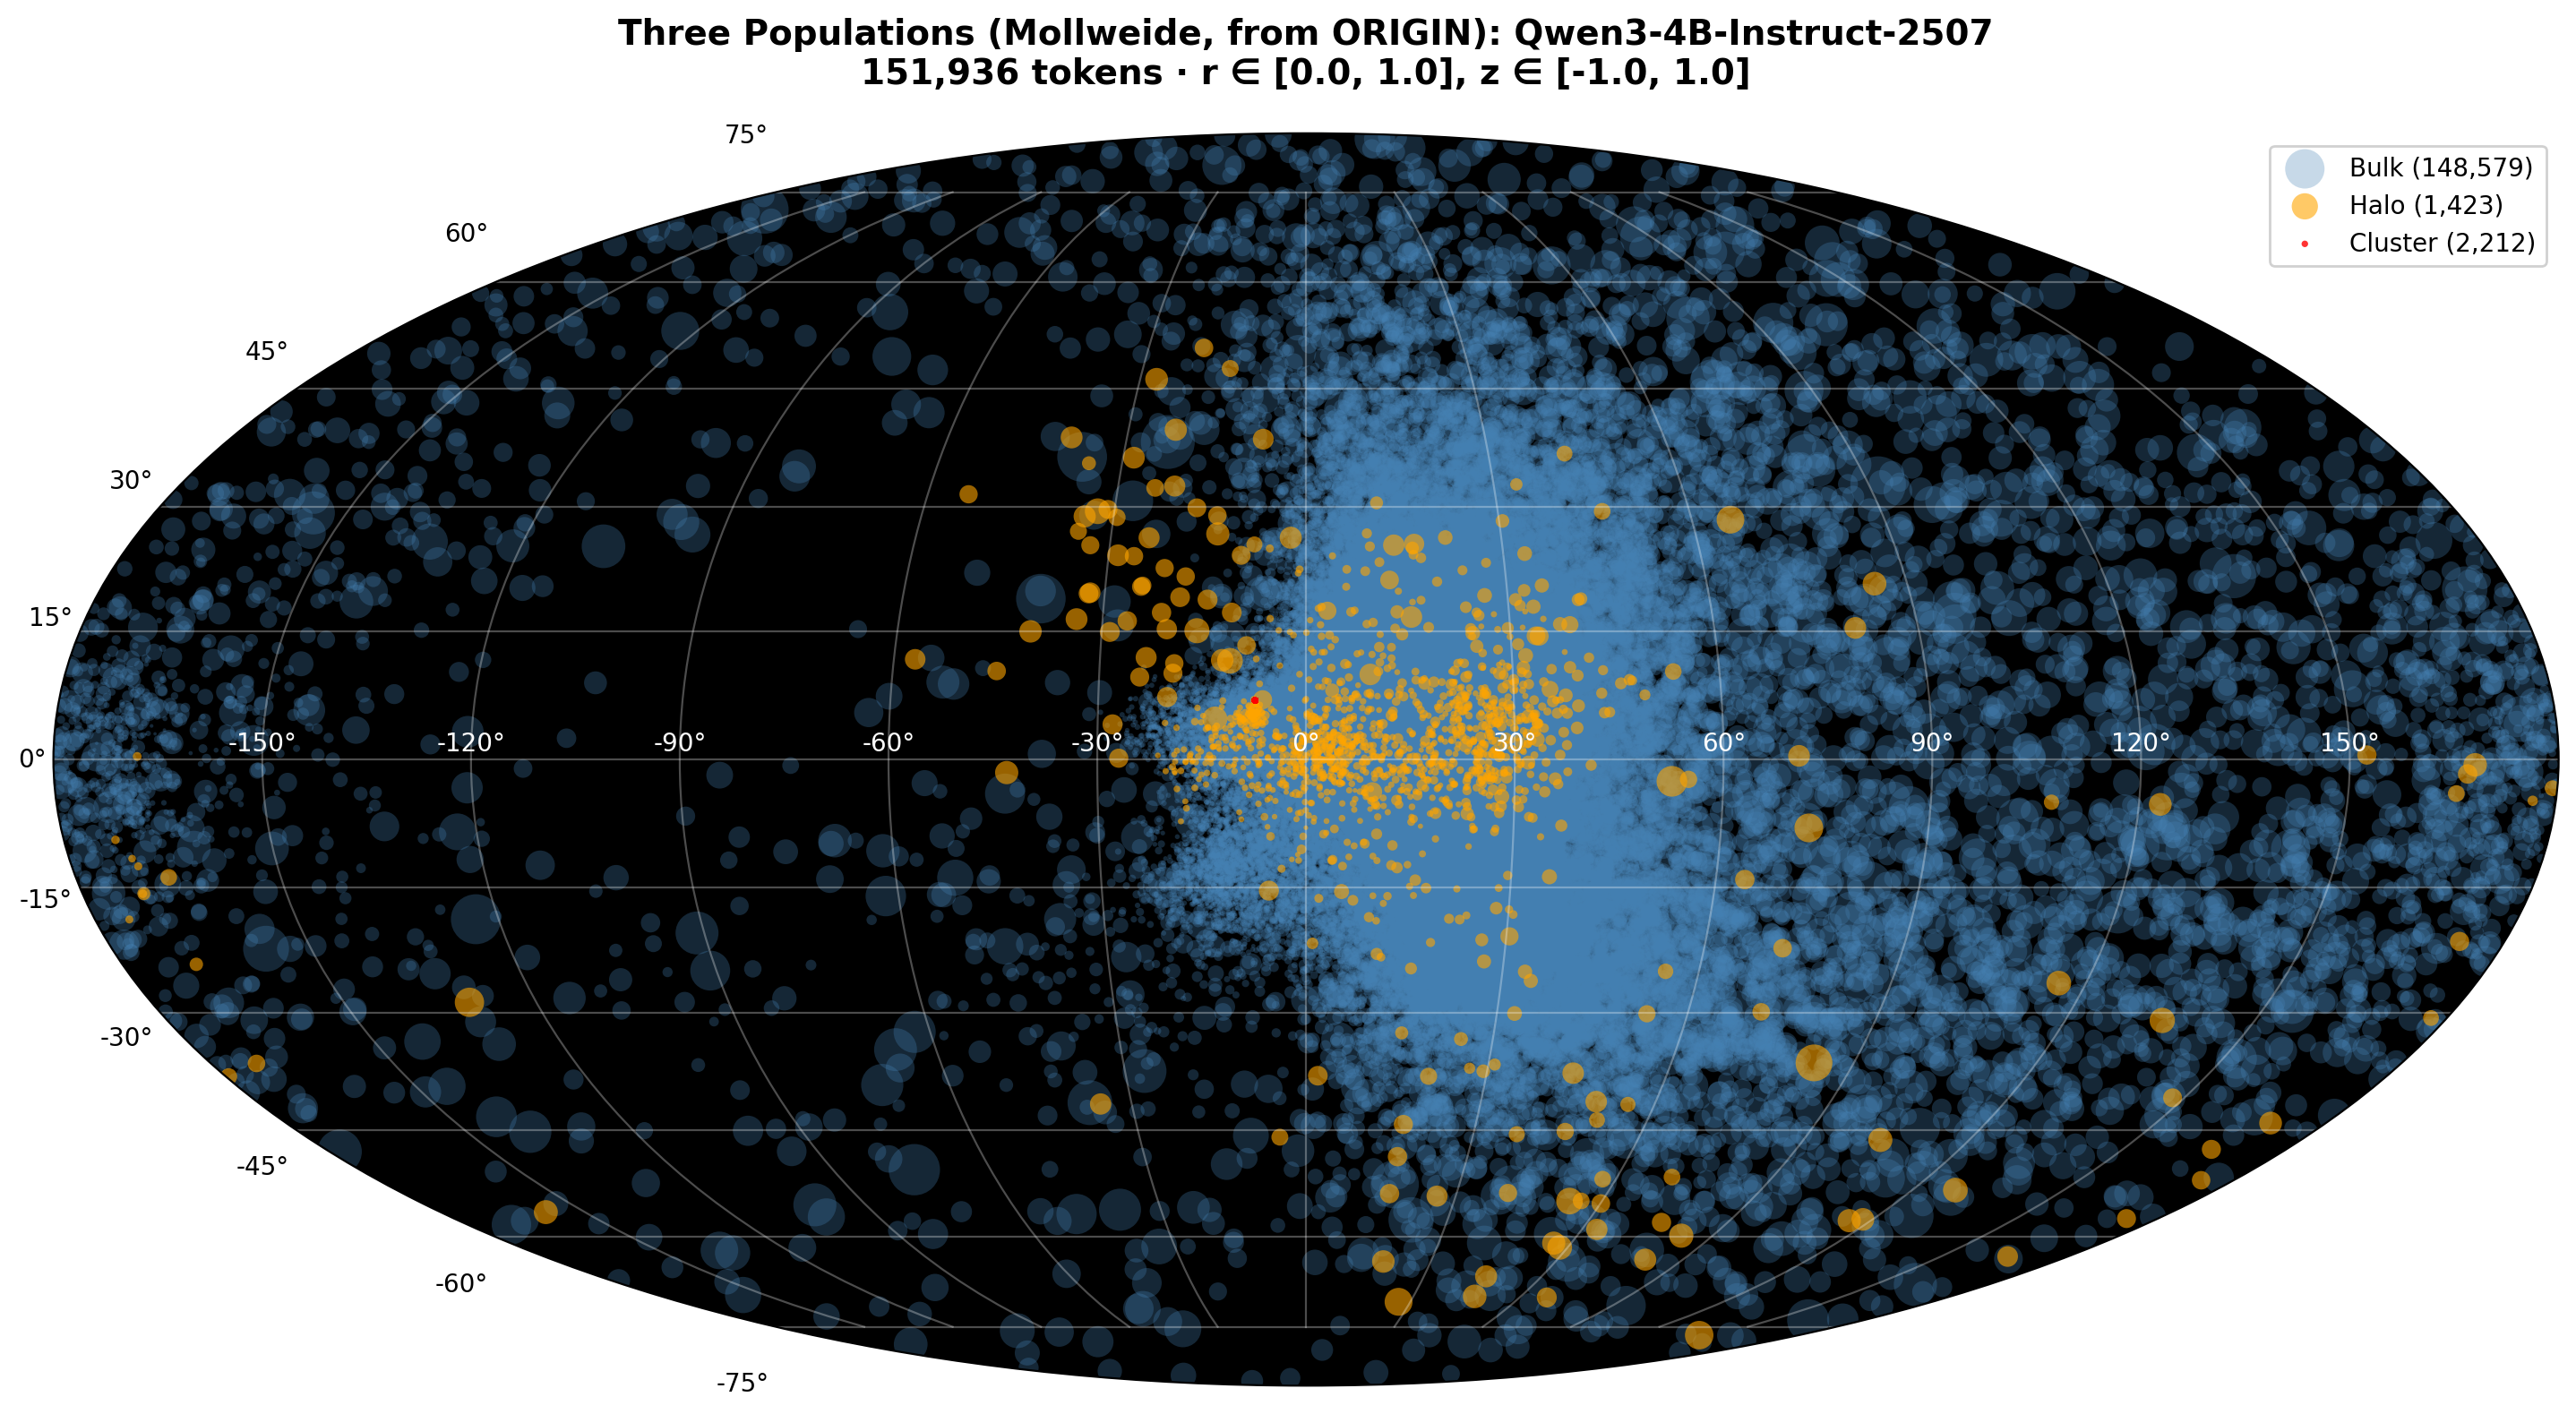

✓ Mollweide sky map complete


In [36]:
print(f"\nCreating Mollweide sky map (view from origin)...\n")

# Convert to radians for plotting
lon_rad_np = np.deg2rad(lon_np)
lat_rad_np = np.deg2rad(lat_np)

# Convert population masks to numpy
cluster_mask_np = cluster_mask_filtered.cpu().numpy()
halo_mask_np = halo_mask_filtered.cpu().numpy()
bulk_mask_np = bulk_mask_filtered.cpu().numpy()

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Plot in order: bulk (background), halo (middle), cluster (foreground)

# Bulk (blue, varies by distance)
if bulk_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[bulk_mask_np], lat_rad_np[bulk_mask_np],
               s=sizes[bulk_mask_np],
               alpha=BULK_ALPHA,
               c=BULK_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Bulk ({bulk_mask_np.sum():,})')

# Halo (orange, varies by distance)
if halo_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[halo_mask_np], lat_rad_np[halo_mask_np],
               s=sizes[halo_mask_np],
               alpha=HALO_ALPHA,
               c=HALO_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Halo ({halo_mask_np.sum():,})')

# Cluster (red, varies by distance)
if cluster_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[cluster_mask_np], lat_rad_np[cluster_mask_np],
               s=sizes[cluster_mask_np],
               alpha=CLUSTER_ALPHA,
               c=CLUSTER_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Cluster ({cluster_mask_np.sum():,})')

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
ax.set_title(f'Three Populations (Mollweide, from ORIGIN): {MODEL_NAME}\n' +
             f'{n_filtered:,} tokens · r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN}, {Z_MAX}]',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide sky map complete")

## Polar (Equatorial) Plot: Three Populations


Creating polar equatorial plot (view from origin)...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_29122/411785141.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])


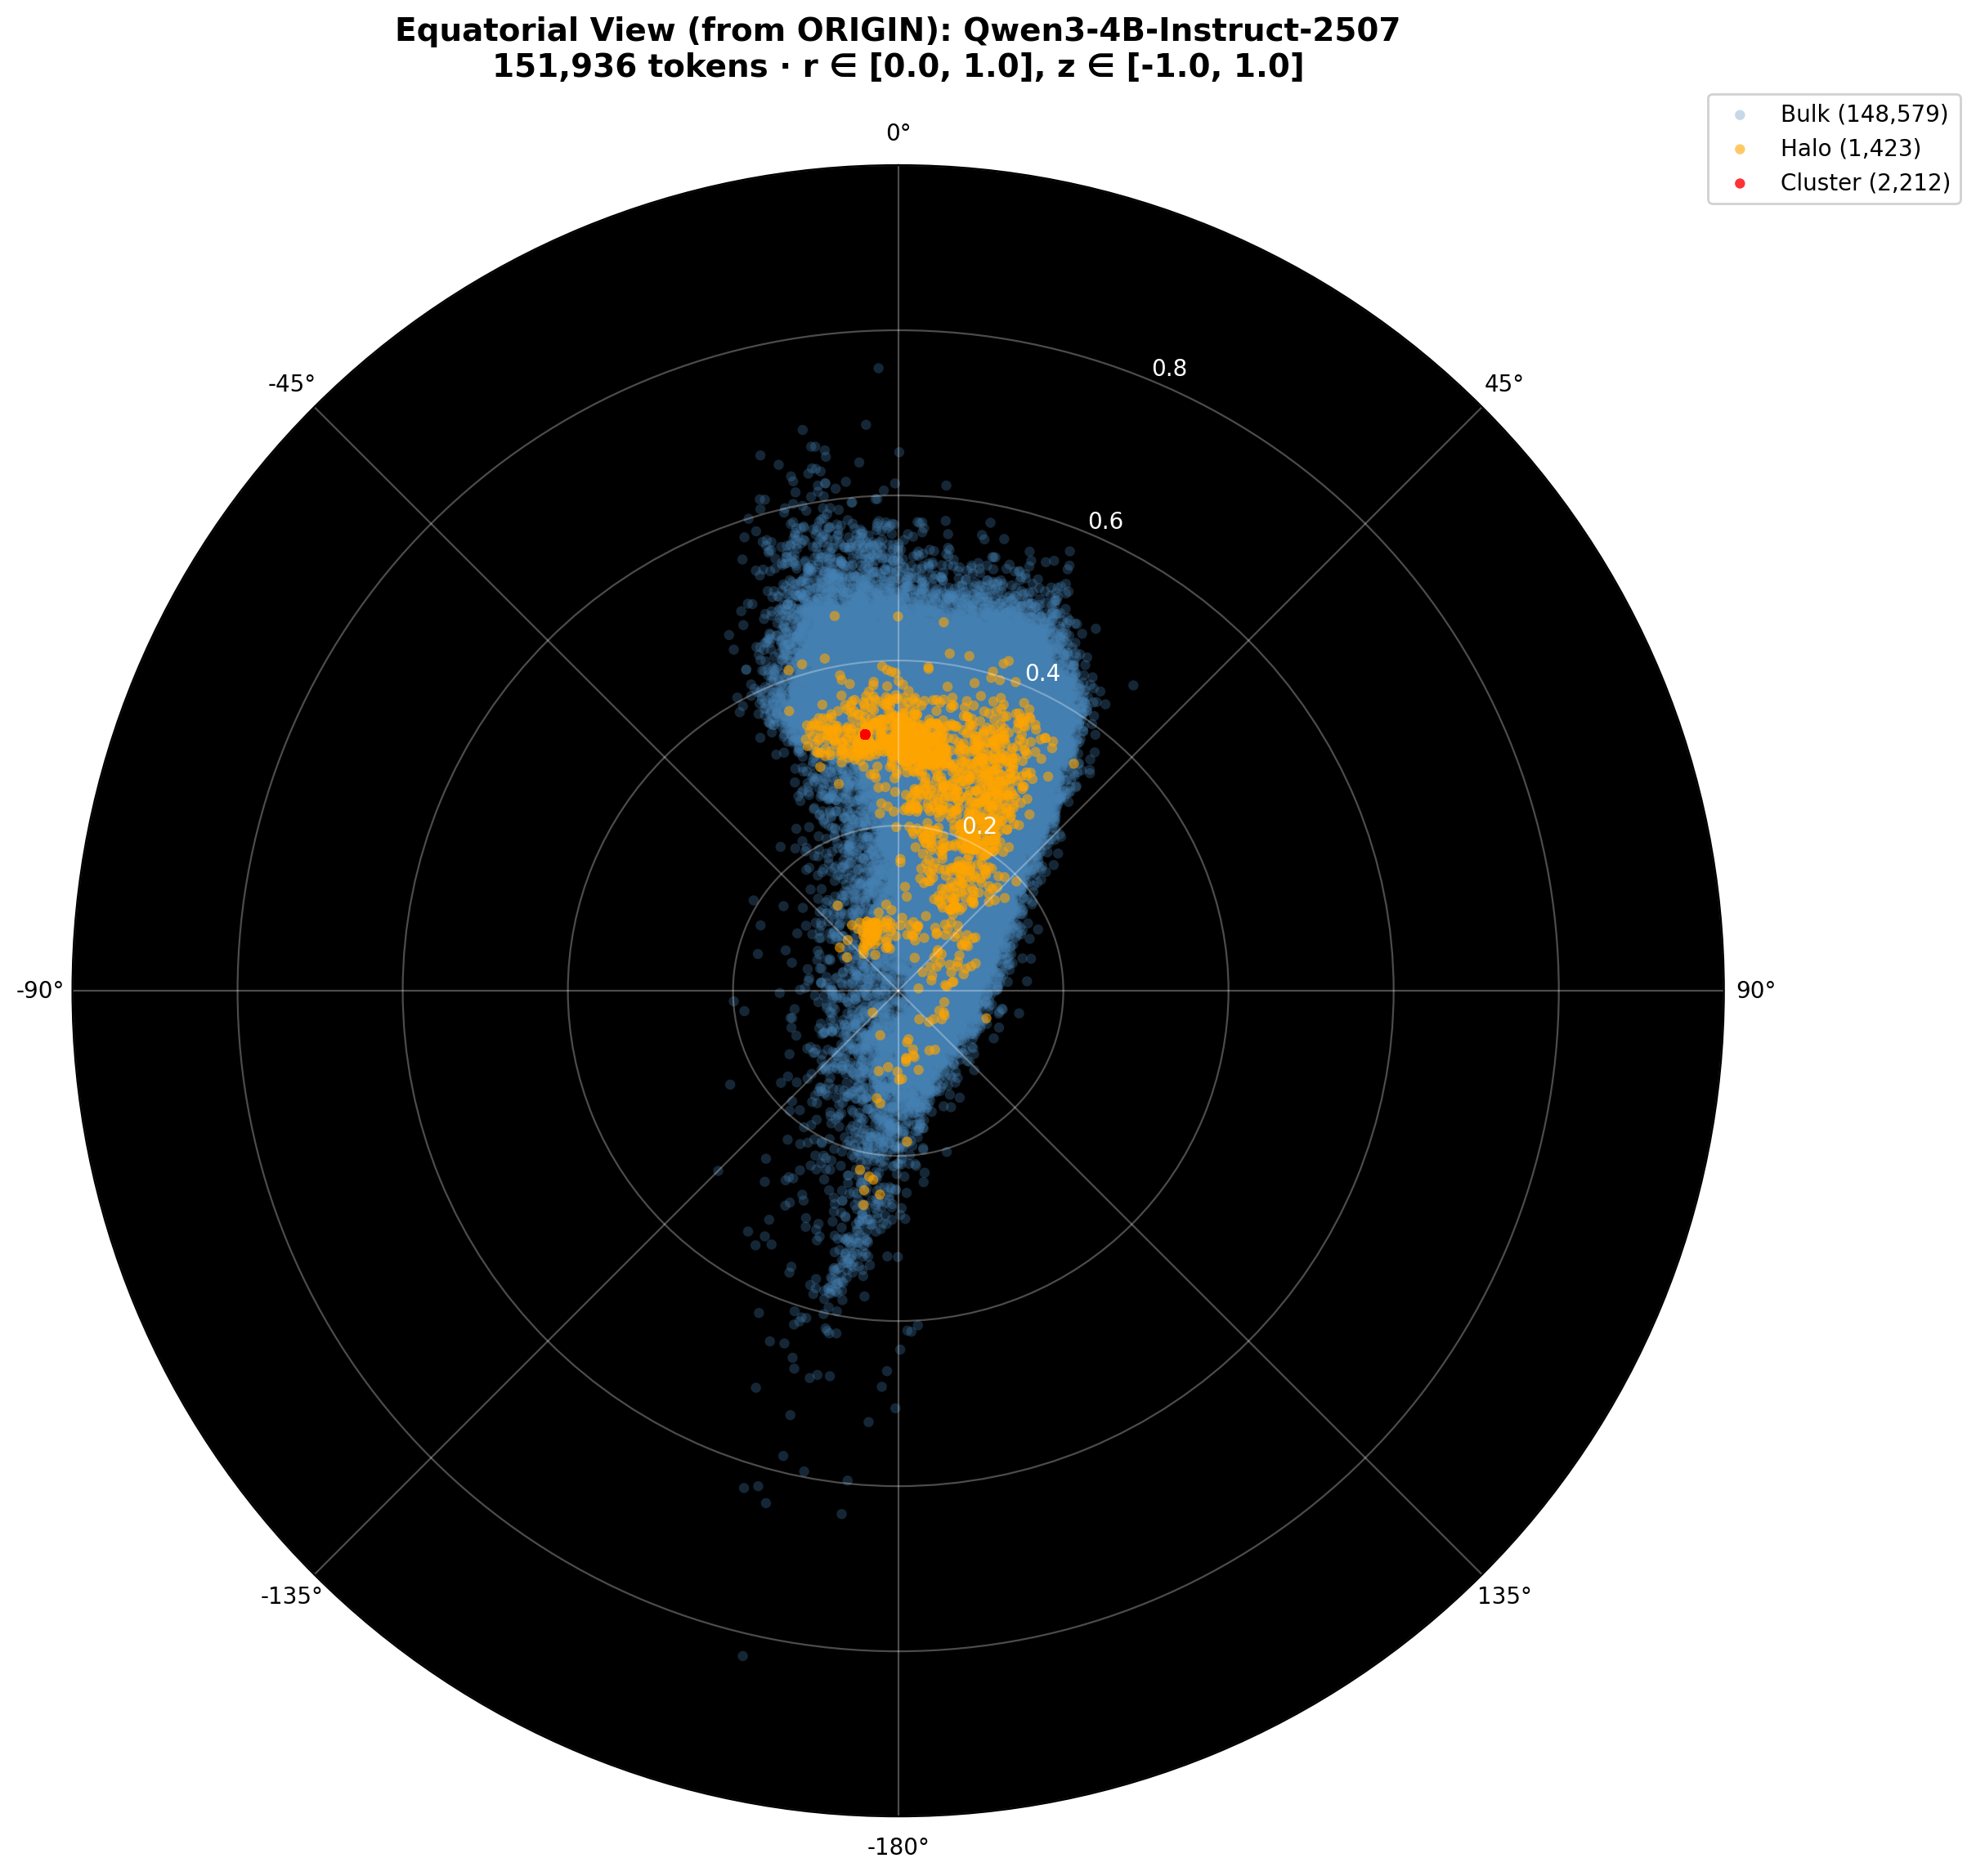

✓ Polar equatorial plot complete


In [37]:
print(f"\nCreating polar equatorial plot (view from origin)...\n")

# Create figure
fig = plt.figure(figsize=(12, 12), dpi=DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Fixed size for polar plot (distance already encoded in radius)
POLAR_SIZE = 20.0

# Plot in order: bulk, halo, cluster

# Bulk (blue)
if bulk_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[bulk_mask_np], r_np[bulk_mask_np],
               s=POLAR_SIZE,
               alpha=BULK_ALPHA,
               c=BULK_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Bulk ({bulk_mask_np.sum():,})')

# Halo (orange)
if halo_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[halo_mask_np], r_np[halo_mask_np],
               s=POLAR_SIZE,
               alpha=HALO_ALPHA,
               c=HALO_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Halo ({halo_mask_np.sum():,})')

# Cluster (red)
if cluster_mask_np.sum() > 0:
    ax.scatter(lon_rad_np[cluster_mask_np], r_np[cluster_mask_np],
               s=POLAR_SIZE,
               alpha=CLUSTER_ALPHA,
               c=CLUSTER_COLOR,
               edgecolors='none',
               rasterized=True,
               label=f'Cluster ({cluster_mask_np.sum():,})')

# Formatting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True, alpha=0.3, color='white')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05), framealpha=0.9, fontsize=10)
ax.set_title(f'Equatorial View (from ORIGIN): {MODEL_NAME}\n' +
             f'{n_filtered:,} tokens · r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN}, {Z_MAX}]',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Get the default tick positions (in radians)
tick_locs = ax.get_xticks()

# Convert each tick from radians to degrees
tick_degs = np.rad2deg(tick_locs)

# Wrap to -180 to 180 range
tick_degs = ((tick_degs + 180) % 360) - 180

# Set the labels (but keep original positions)
ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('black')
for label in ax.get_yticklabels():
    label.set_color('white')

# Set radial limits to match filtered data
ax.set_rlim(bottom=R_MIN, top=R_MAX)

plt.tight_layout()
plt.show()

print("✓ Polar equatorial plot complete")

## Observations

### What does God see?

Viewing from the coordinate origin reveals the absolute geometry:

**Key questions:**
1. Is the vocabulary distributed **symmetrically** around origin?
2. Where is the **cluster** relative to origin? (Expected: very close, ~0.37 from origin)
3. Does the **asymmetry** we saw from cluster perspective persist from origin?
4. Are tokens **expanding outward** from origin, or is structure more complex?

**Possible outcomes:**

**Symmetric expansion:**
- Tokens distributed uniformly in all directions from origin
- Cluster appears as small structure near origin
- Halo and bulk spread evenly across sky

**Asymmetric structure:**
- Tokens concentrated in specific directions
- Filamentary or multipolar distribution
- Cluster may be offset from origin

**Interpretation:**
- Origin is the **initialization point** (where training began)
- Current distribution shows how training **moved** tokens from this point
- Asymmetry from origin → systematic training dynamics (not random diffusion)